In [1]:
from os.path import join
from os import makedirs
import matplotlib.pyplot as plt
from unet import CBIS_DDSM_get_DataLoader

from skimage import io
import SimpleITK as sitk
import numpy as np


In [3]:
train_images_filename='unet_trainfiles.txt'
test_images_filename='unet_testfiles.txt'
train_images_directory="/usr/xtmp/vs196/mammoproj/Data/unet_cbisddsm_border/Train/"
test_images_directory="/usr/xtmp/vs196/mammoproj/Data/unet_cbisddsm_border/Test/"

## See what the data looks like 

In [8]:
batch_size = 2
num_workers = 1
train_dl, test_dl = CBIS_DDSM_get_DataLoader(batch_size,num_workers,has_weights=True,
    train_images_filename=train_images_filename,
    test_images_filename=test_images_filename,
    train_images_directory=train_images_directory,
    test_images_directory=test_images_directory)

In [4]:
img, mask, weights = next(iter(train_dl))

In [5]:
img.shape

torch.Size([2, 1, 256, 256])

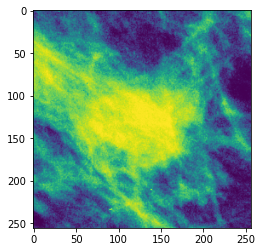

In [25]:
plt.imshow(img[0,0,:])


In [44]:
np.sum(np.array(mask == 0))

109180

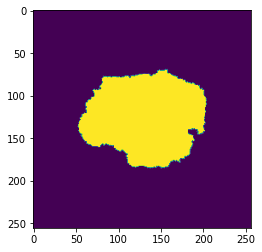

In [26]:
plt.imshow(mask[0,0,:])

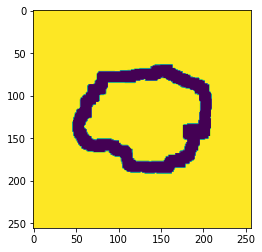

In [27]:
plt.imshow(weights[0,0,:])

## Convert image data into nnunet format 

In [56]:
def convert_2d_image_to_nifti(img, output_filename_truncated: str, spacing=(999, 1, 1),
                              transform=None, is_seg: bool = False) -> None:
    """
    Reads an image (must be a format that it recognized by skimage.io.imread) and converts it into a series of niftis.
    The image can have an arbitrary number of input channels which will be exported separately (_0000.nii.gz,
    _0001.nii.gz, etc for images and only .nii.gz for seg).
    Spacing can be ignored most of the time.
    !!!2D images are often natural images which do not have a voxel spacing that could be used for resampling. These images
    must be resampled by you prior to converting them to nifti!!!
    Datasets converted with this utility can only be used with the 2d U-Net configuration of nnU-Net
    If Transform is not None it will be applied to the image after loading.
    Segmentations will be converted to np.uint32!
    :param is_seg:
    :param transform:
    :param input_filename:
    :param output_filename_truncated: do not use a file ending for this one! Example: output_name='./converted/image1'. This
    function will add the suffix (_0000) and file ending (.nii.gz) for you.
    :param spacing:
    :return:
    """

    if transform is not None:
        img = transform(img)

    if len(img.shape) == 2:  # 2d image with no color channels
        img = img[None, None]  # add dimensions
    else:
        assert len(img.shape) == 3, "image should be 3d with color channel last but has shape %s" % str(img.shape)
        # we assume that the color channel is the last dimension. Transpose it to be in first
        img = img.transpose((2, 0, 1))
        # add third dimension
        img = img[:, None]

    # image is now (c, x, x, z) where x=1 since it's 2d
    if is_seg:
        assert img.shape[0] == 1, 'segmentations can only have one color channel, not sure what happened here'

    for j, i in enumerate(img):

        if is_seg:
            i = i.astype(np.uint32)

        itk_img = sitk.GetImageFromArray(i)
        itk_img.SetSpacing(list(spacing)[::-1])
        if not is_seg:
            # print(f"saving to {output_filename_truncated} _%04.0d.nii.gz ")
            sitk.WriteImage(itk_img, output_filename_truncated + "_%04.0d.nii.gz" % j)
        else:
            # print(f"saving to {output_filename_truncated}.nii.gz")
            sitk.WriteImage(itk_img, output_filename_truncated + ".nii.gz")
        return itk_img

In [4]:
nnUNet_raw_data = '/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/'

base = '/usr/xtmp/vs196/mammoproj/Data/unet_cbisddsm_border/'
train_images_filename='unet_trainfiles.txt'
test_images_filename='unet_testfiles.txt'
# this folder should have the training and testing subfolders

# now start the conversion to nnU-Net:
task_name = 'Task501_cbis-ddsm'
target_base = join(nnUNet_raw_data, task_name)
target_imagesTr = join(target_base, "imagesTr")
target_imagesTs = join(target_base, "imagesTs")
target_labelsTs = join(target_base, "labelsTs")
target_labelsTr = join(target_base, "labelsTr")

In [ ]:
makedirs(target_imagesTr, exist_ok=True)
makedirs(target_labelsTs, exist_ok=True)
makedirs(target_imagesTs, exist_ok=True)
makedirs(target_labelsTr, exist_ok=True)

In [60]:
# convert the training examples.
input_dir_tr = join(base, 'Train')

training_cases = []
with open(train_images_filename,'r') as train_file:
    for line in train_file.readlines():
        training_cases.append(line[2:-1])

for t in training_cases:
    unique_name = t[:-4]  # just the filename with the extension cropped away, so img-2.png becomes img-2 as unique_name
    input_file = join(input_dir_tr, t)

    img = np.load(input_file)
    img = img.copy()

    output_image_file = join(target_imagesTr, unique_name)  # do not specify a file ending! This will be done for you
    output_seg_file = join(target_labelsTr, unique_name)  # do not specify a file ending! This will be done for you
    # this utility will convert 2d images that can be read by skimage.io.imread to nifti. You don't need to do anything.
    # if this throws an error for your images, please take a look at the code for this function and adapt it to your needs
    test_img = convert_2d_image_to_nifti(img[0].copy(), output_image_file, is_seg=False)

    # nnU-Net expects the labels to be consecutive integers. This can be achieved with setting a transform
    test_seg = convert_2d_image_to_nifti(img[1].copy(), output_seg_file, is_seg=True,
                                transform=lambda x: (x >= 1).astype(int))


/usr/xtmp/vs196/mammoproj/Data/unet_cbisddsm_border/Train/DP_00173_RIGHT_MLO_1.npy


FileNotFoundError: [Errno 2] No such file or directory: '/usr/xtmp/vs196/mammoproj/Data/unet_cbisddsm_border/Train/DP_00173_RIGHT_MLO_1.npy'

In [ ]:
# now do the same for the test set
base = '/usr/xtmp/vs196/mammoproj/Data/unet_cbisddsm/'

input_dir_ts = join(base, 'Train')
testing_cases = []
with open(test_images_filename,'r') as test_file:
    for line in test_file.readlines():
        testing_cases.append(line[2:-1])

for t in testing_cases:
    unique_name = t[:-4]  # just the filename with the extension cropped away, so img-2.png becomes img-2 as unique_name
    input_file = join(input_dir_ts, t)
    print(input_file)
    img = np.load(input_file)
    img = img.copy()

    output_image_file = join(target_imagesTs, unique_name)  # do not specify a file ending! This will be done for you
    output_seg_file = join(target_labelsTs, unique_name)  # do not specify a file ending! This will be done for you
    # this utility will convert 2d images that can be read by skimage.io.imread to nifti. You don't need to do anything.
    # if this throws an error for your images, please just look at the code for this function and adapt it to your needs
    test_img = convert_2d_image_to_nifti(img[0].copy(), output_image_file, is_seg=False)

    # nnU-Net expects the labels to be consecutive integers. This can be achieved with setting a transform
    test_seg = convert_2d_image_to_nifti(img[1].copy(), output_seg_file, is_seg=True,
                                transform=lambda x: (x >= 1).astype(int))


## Visualize conversion Results

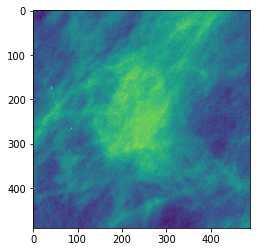

In [48]:
test_img_sitk = sitk.GetArrayFromImage(test_img)
plt.imshow(test_img_sitk[0])

In [61]:
test_seg_sitk.shape

(1, 490, 489)

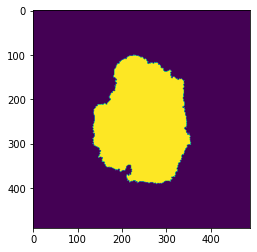

In [49]:
test_seg_sitk = sitk.GetArrayFromImage(test_seg)
plt.imshow(test_seg_sitk[0])

## Make json

In [1]:
#    Copyright 2020 Division of Medical Image Computing, German Cancer Research Center (DKFZ), Heidelberg, Germany
#
#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at
#
#        http://www.apache.org/licenses/LICENSE-2.0
#
#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.


from typing import Tuple
import numpy as np
from batchgenerators.utilities.file_and_folder_operations import *


def get_identifiers_from_splitted_files(folder: str):
    uniques = np.unique([i[:-12] for i in subfiles(folder, suffix='.nii.gz', join=False)])
    return uniques


def generate_dataset_json(output_file: str, imagesTr_dir: str, imagesTs_dir: str, modalities: Tuple,
                          labels: dict, dataset_name: str, sort_keys=True, license: str = "hands off!", dataset_description: str = "",
                          dataset_reference="", dataset_release='0.0'):
    """
    :param output_file: This needs to be the full path to the dataset.json you intend to write, so
    output_file='DATASET_PATH/dataset.json' where the folder DATASET_PATH points to is the one with the
    imagesTr and labelsTr subfolders
    :param imagesTr_dir: path to the imagesTr folder of that dataset
    :param imagesTs_dir: path to the imagesTs folder of that dataset. Can be None
    :param modalities: tuple of strings with modality names. must be in the same order as the images (first entry
    corresponds to _0000.nii.gz, etc). Example: ('T1', 'T2', 'FLAIR').
    :param labels: dict with int->str (key->value) mapping the label IDs to label names. Note that 0 is always
    supposed to be background! Example: {0: 'background', 1: 'edema', 2: 'enhancing tumor'}
    :param dataset_name: The name of the dataset. Can be anything you want
    :param sort_keys: In order to sort or not, the keys in dataset.json
    :param license:
    :param dataset_description:
    :param dataset_reference: website of the dataset, if available
    :param dataset_release:
    :return:
    """
    train_identifiers = get_identifiers_from_splitted_files(imagesTr_dir)

    if imagesTs_dir is not None:
        test_identifiers = get_identifiers_from_splitted_files(imagesTs_dir)
    else:
        test_identifiers = []

    json_dict = {}
    json_dict['name'] = dataset_name
    json_dict['description'] = dataset_description
    json_dict['tensorImageSize'] = "4D"
    json_dict['reference'] = dataset_reference
    json_dict['licence'] = license
    json_dict['release'] = dataset_release
    json_dict['modality'] = {str(i): modalities[i] for i in range(len(modalities))}
    json_dict['labels'] = {str(i): labels[i] for i in labels.keys()}

    json_dict['numTraining'] = len(train_identifiers)
    json_dict['numTest'] = len(test_identifiers)
    json_dict['training'] = [
        {'image': "./imagesTr/%s.nii.gz" % i, "label": "./labelsTr/%s.nii.gz" % i} for i
        in
        train_identifiers]
    json_dict['test'] = ["./imagesTs/%s.nii.gz" % i for i in test_identifiers]

    if not output_file.endswith("dataset.json"):
        print("WARNING: output file name is not dataset.json! This may be intentional or not. You decide. "
              "Proceeding anyways...")
    save_json(json_dict, os.path.join(output_file), sort_keys=sort_keys)

In [7]:
# finally we can call the utility for generating a dataset.json
generate_dataset_json(join(target_base, 'dataset.json'), target_imagesTr, target_imagesTs, ('RGB',),
                        labels={0: 'background', 1: 'lesion'}, dataset_name=task_name, license='hands off!')


MAKE SURE TO GO INTO ~/.my-bashrc and add the below 3 lines (REPLACE THE PATHS WITH YOUR PATHS): 

export nnUNet_raw_data_base="/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base"
export nnUNet_preprocessed="/usr/xtmp/jly16/mammoproj/data/nnUNet_preprocessed"
export RESULTS_FOLDER="/usr/xtmp/jly16/mammoproj/data/nnUNet_trained_models"

In [ ]:

"""
once this is completed, you can use the dataset like any other nnU-Net dataset. Note that since this is a 2D
dataset there is no need to run preprocessing for 3D U-Nets. You should therefore run the 
`nnUNet_plan_and_preprocess` command like this:

> nnUNet_plan_and_preprocess -t 120 -pl3d None

once that is completed, you can run the trainings as follows:
> nnUNet_train 2d nnUNetTrainerV2 120 FOLD

(where fold is again 0, 1, 2, 3 and 4 - 5-fold cross validation)

there is no need to run nnUNet_find_best_configuration because there is only one model to choose from.
Note that without running nnUNet_find_best_configuration, nnU-Net will not have determined a postprocessing
for the whole cross-validation. Spoiler: it will determine not to run postprocessing anyways. If you are using
a different 2D dataset, you can make nnU-Net determine the postprocessing by using the
`nnUNet_determine_postprocessing` command
"""

## Now do the preprocessing

In [8]:
! nnUNet_plan_and_preprocess -t 501 --verify_dataset_integrity



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Verifying training set
checking case DP_00001_LEFT_CC_1
checking case DP_00001_LEFT_MLO_1
checking case DP_00004_LEFT_CC_1
checking case DP_00004_LEFT_MLO_1
checking case DP_00004_RIGHT_MLO_1
checking case DP_00009_RIGHT_CC_1
checking case DP_00009_RIGHT_MLO_1
checking case DP_00015_LEFT_MLO_1
checking case DP_00018_RIGHT_CC_1
checking case DP_00018_RIGHT_MLO_1
checking case DP_00021_LEFT_CC_1
checking case DP_00021_LEFT_MLO_1
checking case DP_00021_RIGHT_CC_1
checking case DP_00021_RIGHT_MLO_1
checking case DP_00023_RIGHT_CC_1
checking case DP_00023_RIGHT_MLO_1
checking case DP_00026_LEFT_CC_1
checking case DP_00026_LEFT_MLO_1
ch

## And finally run the training!

In [33]:
! sbatch train_nnunet.sh
## Fold = 0 

Submitted batch job 2781311


In [6]:
! sbatch train_nnunet.sh
# fold = 1

Submitted batch job 2765172


## Try some manual inferences? 

In [ ]:
nnUNet_raw_data = '/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/'

# now start the conversion to nnU-Net:
task_name = 'Task501_cbis-ddsm'
target_base = join(nnUNet_raw_data, task_name)
target_imagesTr = join(target_base, "imagesTr")
target_imagesTs = join(target_base, "imagesTs")
target_labelsTs = join(target_base, "labelsTs")
target_labelsTr = join(target_base, "labelsTr")

pkl = "/home/fabian/PhD/results/nnUNetV2/nnUNetV2_3D_fullres/Task004_Hippocampus/fold0/model_best.model.pkl"
checkpoint = pkl[:-4]
train = False
trainer = restore_model(pkl, checkpoint, train)


## SCRATCH/SANDBOX BELOW

In [ ]:
img = np.load(
    '/usr/xtmp/mammo/image_datasets/cbis_ddsm/splitby_shape_hasFA/Train/OVAL/DP_00797_LEFT_MLO_1.npy')

In [ ]:
img.shape

(2, 512, 512)

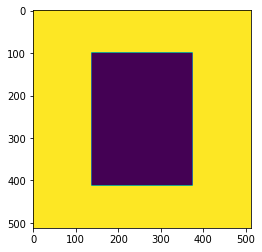

In [ ]:
plt.imshow(img[1])

In [18]:
testing_cases2 = []
with open('test.txt','r') as test_file:
    for line in test_file.readlines():
        testing_cases2.append(line[2:-1])

In [16]:
testing_cases.sort()

In [4]:
import numpy as np

In [12]:
blah = []
# blah = [i for i in [2 * i / (2 * i + j + k) for i, j, k in
#                                            zip((1,2,3), (1,2,2), (2,1,1))]
#                                if not np.isnan(i)]

In [7]:
len(blah)

3

In [13]:
blah.append([1,2,3])

In [14]:
blah.append([4,5,6])

In [15]:
blah

[[1, 2, 3], [4, 5, 6]]

In [18]:
len(blah)

2